# Capstone Project - The Battle of Neighborhoods 


First we import the libraries that will be required to process the data.

In [215]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Download and Explore Dataset


In order to segement the neighborhoods and explore them, we need a dataset that contains boroughs and the neighborhoods of New York.
This dataset is available online as a JSON file together with the latitude and logitude coordinates of each neighborhood.

Here is the link to the dataset: https://cocl.us/new_york_dataset



In [216]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


## Transform the data into a pandas dataframe

In [217]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [218]:
neighborhoods_data = newyork_data['features']

In [219]:
neighborhoods_data = newyork_data['features']
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Examine the resulting dataframe.

In [220]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Use geopy library to get the latitude and longitude values of New York City.
In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent ny_explorer, as shown below.

In [221]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a map of New York with neighborhoods superimposed on top.

In [222]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='white',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

Since we will be looking at possible locations for reastaurant in Manhattan, we simplify the above map and segment and cluster only the neighborhoods in Manhattan. 

So let's slice the original dataframe and create a new dataframe of the Manhattan data.

In [223]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


Now we create a map with superimposed neighbohoods in Manhattan

In [224]:

import folium
# create map of New York using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Borough'], manhattan_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='white',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

##  Explore Neighborhoods in Manhattan

### We create a function to repeat the same process to all the neighborhoods in Manhattan

#### We are going to look for Thai Restaurants using its Foursquare Category ID

In [225]:

import urllib
def getNearbyVenues(names, latitudes, longitudes, radius=5000, categoryIds=''):
    try:
        venues_list=[]
        for name, lat, lng in zip(names, latitudes, longitudes):
            #print(name)

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)

            if (categoryIds != ''):
                url = url + '&categoryId={}'
                url = url.format(categoryIds)

            # make the GET request
            response = requests.get(url).json()
            results = response["response"]['venues']

            # return only relevant information for each nearby venue
            for v in results:
                success = False
                try:
                    category = v['categories'][0]['name']
                    success = True
                except:
                    pass

                if success:
                    venues_list.append([(
                        name, 
                        lat, 
                        lng, 
                        v['name'], 
                        v['location']['lat'], 
                        v['location']['lng'],
                        v['categories'][0]['name']
                    )])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',  
                  'Venue Category']
    
    except:
        print(url)
        print(response)
        print(results)
        print(nearby_venues)

    return(nearby_venues)

#### Define Foursquare Credentials and Version

In [226]:
CLIENT_ID = 'E1PMPUAUD5BFM1BXWRUHPTLMDVIMSFRSZLIBWLTZP33AKK33' # your Foursquare ID
CLIENT_SECRET = 'KMJ5CCT5FVK3P2GXRAA2CDESLKH41VZ3FUFWPJCVG1FDCRNC' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 500
radius = 5000
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: E1PMPUAUD5BFM1BXWRUHPTLMDVIMSFRSZLIBWLTZP33AKK33
CLIENT_SECRET:KMJ5CCT5FVK3P2GXRAA2CDESLKH41VZ3FUFWPJCVG1FDCRNC


### We run the above function with the created URL and a Category ID for Thai Restaurant on each neighborhood, and create a new dataframe called ny_venues_thai



In [227]:
#https://developer.foursquare.com/docs/resources/categories
#Thai Restaurant = 4bf58dd8d48988d149941735

neighborhoods = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
ny_venues_thai = getNearbyVenues(names=neighborhoods['Neighborhood'], latitudes=neighborhoods['Latitude'], longitudes=neighborhoods['Longitude'], radius=1000, categoryIds='4bf58dd8d48988d149941735')
ny_venues_thai.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.910660,Siam Square,40.878796,-73.916701,Thai Restaurant
1,Marble Hill,40.876551,-73.910660,Holy Basil,40.881678,-73.914376,Thai Restaurant
2,Marble Hill,40.876551,-73.910660,Nam Thai,40.886211,-73.909991,Thai Restaurant
3,Chinatown,40.715618,-73.994279,Noree Thai Bazaar,40.717900,-73.992966,Thai Restaurant
4,Chinatown,40.715618,-73.994279,Wayla,40.718322,-73.992770,Thai Restaurant


#### Check the size of resulting dataframe

In [228]:
ny_venues_thai.shape

(973, 7)

### Now we create a map of Manhattan with Thai Restaurants superimposed.

In [229]:
def addToMap(df, color, existingMap):
    for lat, lng, local, venue, venueCat in zip(df['Venue Latitude'], df['Venue Longitude'], df['Neighborhood'], df['Venue'], df['Venue Category']):
        label = '{} ({}) - {}'.format(venue, venueCat, local)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7).add_to(existingMap)

In [230]:
map_ny_thai = folium.Map(location=[latitude, longitude], zoom_start=10)
addToMap(ny_venues_thai, 'red', map_ny_thai)

map_ny_thai

#### We can check how many venues are returned for each neighborhood

In [231]:
def addColumn(startDf, columnTitle, dataDf):
    grouped = dataDf.groupby('Neighborhood').count()
    
    for n in startDf['Neighborhood']:
        try:
            startDf.loc[startDf['Neighborhood'] == n,columnTitle] = grouped.loc[n, 'Venue']
        except:
            startDf.loc[startDf['Neighborhood'] == n,columnTitle] = 0

In [232]:
manhattan_grouped = ny_venues_thai.groupby('Neighborhood').count()
manhattan_grouped

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,10,10,10,10,10,10
Carnegie Hill,25,25,25,25,25,25
Central Harlem,4,4,4,4,4,4
Chelsea,29,29,29,29,29,29
Chinatown,33,33,33,33,33,33
Civic Center,22,22,22,22,22,22
Clinton,48,48,48,48,48,48
East Harlem,12,12,12,12,12,12
East Village,48,48,48,48,48,48


In [233]:
print('There are {} uniques categories.'.format(len(ny_venues_thai['Venue Category'].unique())))

There are 11 uniques categories.


## Data Visualization of venues returned for each neighborhood

In [234]:
manhattan_grouped['Venue'].sort_values(ascending=True)

Neighborhood
Washington Heights      2
Inwood                  3
Manhattanville          3
Marble Hill             3
Central Harlem          4
Hamilton Heights        4
Roosevelt Island        9
Battery Park City      10
Morningside Heights    11
Financial District     11
East Harlem            12
Tribeca                15
Lenox Hill             15
Manhattan Valley       15
Upper East Side        16
Upper West Side        16
Sutton Place           17
Stuyvesant Town        19
West Village           20
Yorkville              20
Civic Center           22
Carnegie Hill          25
Soho                   26
Chelsea                29
Turtle Bay             32
Lincoln Square         32
Hudson Yards           32
Tudor City             33
Chinatown              33
Lower East Side        36
Greenwich Village      37
Murray Hill            39
Little Italy           40
Midtown                46
Flatiron               47
Midtown South          47
Noho                   48
East Village           48

In [235]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  2.1.0


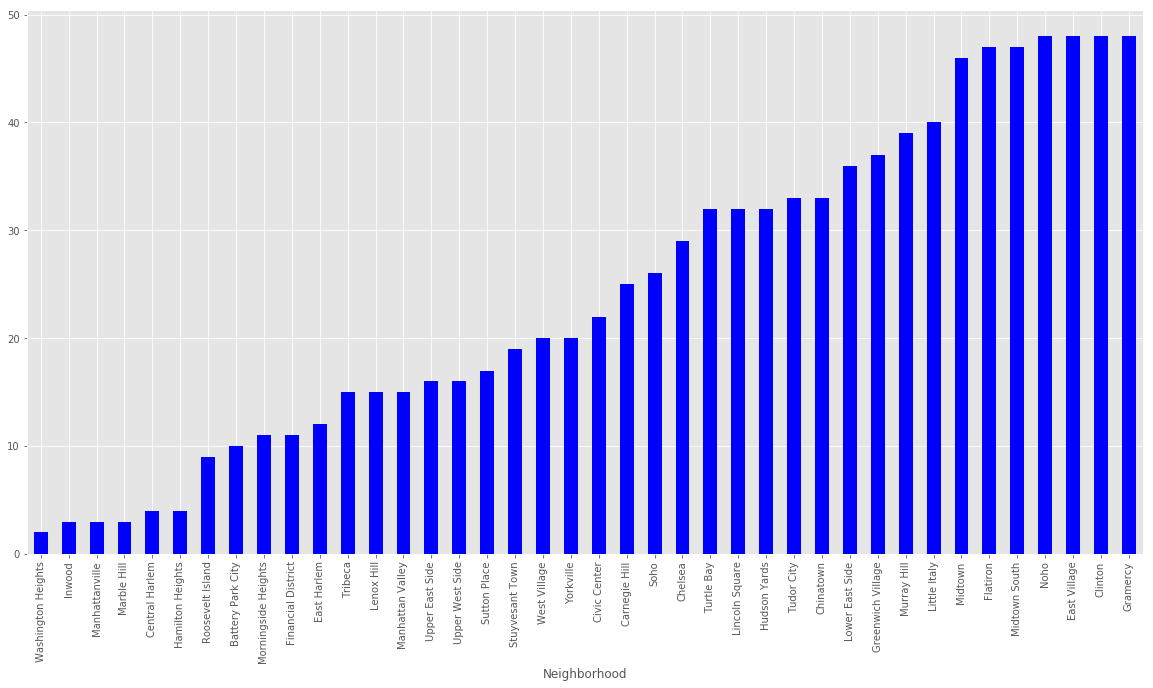

In [236]:
manhattan_grouped['Venue'].sort_values(ascending=True).plot(kind='bar', figsize=(20,10), color="blue")


plt.show()

In the bar plot we can notice that there are neighborhoods low numbers of Thai Restaurant, assigning neighborhoods to clusters will help us to group neighborhoods with similar frequency of occuring Thai Restaurants

## Analyze Each Neighborhood

In [237]:
# one hot encoding
manhattan_onehot = pd.get_dummies(ny_venues_thai[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = ny_venues_thai['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Asian Restaurant,Chinese Restaurant,Food Truck,Indian Restaurant,Japanese Restaurant,Malay Restaurant,Ramen Restaurant,Sushi Restaurant,Thai Restaurant,Vietnamese Restaurant,Wine Bar
0,Marble Hill,0,0,0,0,0,0,0,0,1,0,0
1,Marble Hill,0,0,0,0,0,0,0,0,1,0,0
2,Marble Hill,0,0,0,0,0,0,0,0,1,0,0
3,Chinatown,0,0,0,0,0,0,0,0,1,0,0
4,Chinatown,0,0,0,0,0,0,0,0,1,0,0


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [238]:
manhattan_grouped2 = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped2

,Neighborhood,Asian Restaurant,Chinese Restaurant,Food Truck,Indian Restaurant,Japanese Restaurant,Malay Restaurant,Ramen Restaurant,Sushi Restaurant,Thai Restaurant,Vietnamese Restaurant,Wine Bar
0,Battery Park City,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.900000,0.000000,0.000000
1,Carnegie Hill,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.960000,0.000000,0.000000
2,Central Harlem,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
3,Chelsea,0.000000,0.034483,0.034483,0.000000,0.034483,0.034483,0.000000,0.000000,0.862069,0.000000,0.000000
4,Chinatown,0.090909,0.000000,0.000000,0.000000,0.000000,0.030303,0.000000,0.030303,0.818182,0.030303,0.000000
5,Civic Center,0.045455,0.000000,0.000000,0.000000,0.045455,0.045455,0.000000,0.000000,0.863636,0.000000,0.000000
6,Clinton,0.041667,0.020833,0.041667,0.000000,0.000000,0.000000,0.041667,0.000000,0.854167,0.000000,0.000000
7,East Harlem,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
8,East Village,0.041667,0.041667,0.020833,0.000000,0.000000,0.000000,0.000000,0.041667,0.812500,0.020833,0.020833
9,Financial District,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.909091,0.000000,0.000000


### Let's put that into a pandas dataframe
First, let's write a function to sort the venues in descending order.

In [239]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [240]:

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped2['Neighborhood']

for ind in np.arange(manhattan_grouped2.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped2.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Thai Restaurant,Japanese Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Indian Restaurant,Food Truck,Chinese Restaurant
1,Carnegie Hill,Thai Restaurant,Asian Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck
2,Central Harlem,Thai Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck,Chinese Restaurant
3,Chelsea,Thai Restaurant,Malay Restaurant,Japanese Restaurant,Food Truck,Chinese Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Indian Restaurant
4,Chinatown,Thai Restaurant,Asian Restaurant,Vietnamese Restaurant,Sushi Restaurant,Malay Restaurant,Wine Bar,Ramen Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck


# Cluster Neighborhoods
Run k-means to cluster the neighborhood into 5 clusters.

In [241]:
# set number of clusters
kclusters = 5
manhattan_grouped_clustering = manhattan_grouped2.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 1, 3, 0, 2, 2, 0, 3, 2, 4], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [242]:

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,3,Thai Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck,Chinese Restaurant
1,Manhattan,Chinatown,40.715618,-73.994279,2,Thai Restaurant,Asian Restaurant,Vietnamese Restaurant,Sushi Restaurant,Malay Restaurant,Wine Bar,Ramen Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck
2,Manhattan,Washington Heights,40.851903,-73.936900,3,Thai Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck,Chinese Restaurant
3,Manhattan,Inwood,40.867684,-73.921210,3,Thai Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck,Chinese Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,3,Thai Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck,Chinese Restaurant
5,Manhattan,Manhattanville,40.816934,-73.957385,3,Thai Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck,Chinese Restaurant
6,Manhattan,Central Harlem,40.815976,-73.943211,3,Thai Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck,Chinese Restaurant
7,Manhattan,East Harlem,40.792249,-73.944182,3,Thai Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck,Chinese Restaurant
8,Manhattan,Upper East Side,40.775639,-73.960508,1,Thai Restaurant,Asian Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck
9,Manhattan,Yorkville,40.775930,-73.947118,1,Thai Restaurant,Asian Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck


Visualize the resulting clusters

In [244]:

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color='white'[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

## Examine each cluster

### Cluster1

In [245]:
cluster1 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
cluster1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Lincoln Square,Thai Restaurant,Ramen Restaurant,Food Truck,Asian Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant
14,Clinton,Thai Restaurant,Ramen Restaurant,Food Truck,Asian Restaurant,Chinese Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Malay Restaurant,Japanese Restaurant
15,Midtown,Thai Restaurant,Food Truck,Asian Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant
16,Murray Hill,Thai Restaurant,Food Truck,Asian Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant
17,Chelsea,Thai Restaurant,Malay Restaurant,Japanese Restaurant,Food Truck,Chinese Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Indian Restaurant
27,Gramercy,Thai Restaurant,Food Truck,Chinese Restaurant,Sushi Restaurant,Malay Restaurant,Japanese Restaurant,Asian Restaurant,Wine Bar,Vietnamese Restaurant,Ramen Restaurant
33,Midtown South,Thai Restaurant,Food Truck,Japanese Restaurant,Chinese Restaurant,Asian Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant
34,Sutton Place,Thai Restaurant,Food Truck,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Chinese Restaurant
35,Turtle Bay,Thai Restaurant,Food Truck,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Chinese Restaurant
38,Flatiron,Thai Restaurant,Food Truck,Chinese Restaurant,Malay Restaurant,Japanese Restaurant,Asian Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant


### Cluster2

In [246]:
cluster2 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
cluster2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Upper East Side,Thai Restaurant,Asian Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck
9,Yorkville,Thai Restaurant,Asian Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck
12,Upper West Side,Thai Restaurant,Asian Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck
18,Greenwich Village,Thai Restaurant,Asian Restaurant,Sushi Restaurant,Chinese Restaurant,Wine Bar,Vietnamese Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant
21,Tribeca,Thai Restaurant,Asian Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck
26,Morningside Heights,Thai Restaurant,Indian Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Food Truck,Chinese Restaurant
30,Carnegie Hill,Thai Restaurant,Asian Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck
36,Tudor City,Thai Restaurant,Food Truck,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Chinese Restaurant
39,Hudson Yards,Thai Restaurant,Food Truck,Chinese Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant


### Cluster 3

In [247]:
cluster3 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
cluster3

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Chinatown,Thai Restaurant,Asian Restaurant,Vietnamese Restaurant,Sushi Restaurant,Malay Restaurant,Wine Bar,Ramen Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck
19,East Village,Thai Restaurant,Sushi Restaurant,Chinese Restaurant,Asian Restaurant,Wine Bar,Vietnamese Restaurant,Food Truck,Ramen Restaurant,Malay Restaurant,Japanese Restaurant
20,Lower East Side,Thai Restaurant,Asian Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck
22,Little Italy,Thai Restaurant,Asian Restaurant,Vietnamese Restaurant,Sushi Restaurant,Malay Restaurant,Wine Bar,Ramen Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck
23,Soho,Thai Restaurant,Asian Restaurant,Sushi Restaurant,Malay Restaurant,Wine Bar,Vietnamese Restaurant,Ramen Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck
25,Manhattan Valley,Thai Restaurant,Indian Restaurant,Asian Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Food Truck
31,Noho,Thai Restaurant,Asian Restaurant,Sushi Restaurant,Wine Bar,Vietnamese Restaurant,Chinese Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant
32,Civic Center,Thai Restaurant,Malay Restaurant,Japanese Restaurant,Asian Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Indian Restaurant,Food Truck


### Cluster 4

In [248]:
cluster4 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
cluster4

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,Thai Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck,Chinese Restaurant
2,Washington Heights,Thai Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck,Chinese Restaurant
3,Inwood,Thai Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck,Chinese Restaurant
4,Hamilton Heights,Thai Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck,Chinese Restaurant
5,Manhattanville,Thai Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck,Chinese Restaurant
6,Central Harlem,Thai Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck,Chinese Restaurant
7,East Harlem,Thai Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck,Chinese Restaurant
10,Lenox Hill,Thai Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck,Chinese Restaurant
11,Roosevelt Island,Thai Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck,Chinese Restaurant
24,West Village,Thai Restaurant,Chinese Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck


### Cluster 5

In [249]:
cluster5 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
cluster5

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,Battery Park City,Thai Restaurant,Japanese Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Indian Restaurant,Food Truck,Chinese Restaurant
29,Financial District,Thai Restaurant,Japanese Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Indian Restaurant,Food Truck,Chinese Restaurant


## We can find out which cluster has the lowest frequency of occuring Thai Restaurants like this:

### 1)joining the manhattan_grouped Dataframe with the manhattan_merged Dataframe that includes the cluster labels
### 2)cleaning the resulting new Dataframe of unecessary variables
### 3)calculating the average number of Thai Restaurant per Neighborhood in each Cluster using .mean function
### 4)using Data Visualization to recognize the Cluster with least frequent Thai Restaurants
### 5)exploring the recognized Cluster on Map to identify most suitable locations

In [250]:
# joining the manhattan_grouped Dataframe with the manhattan_merged Dataframe that includes the cluster labels
df = pd.DataFrame(manhattan_grouped)
df

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,10,10,10,10,10,10
Carnegie Hill,25,25,25,25,25,25
Central Harlem,4,4,4,4,4,4
Chelsea,29,29,29,29,29,29
Chinatown,33,33,33,33,33,33
Civic Center,22,22,22,22,22,22
Clinton,48,48,48,48,48,48
East Harlem,12,12,12,12,12,12
East Village,48,48,48,48,48,48


In [251]:
# we will replace the index with the corresponding 'Neighborhood' value because the same has been aplied in the Manhattan_grouped Dataframe
df2 = pd.DataFrame(manhattan_merged)
df2 = df2.set_index('Neighborhood')
df2


,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,,,,
Marble Hill,Manhattan,40.876551,-73.910660,3,Thai Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck,Chinese Restaurant
Chinatown,Manhattan,40.715618,-73.994279,2,Thai Restaurant,Asian Restaurant,Vietnamese Restaurant,Sushi Restaurant,Malay Restaurant,Wine Bar,Ramen Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck
Washington Heights,Manhattan,40.851903,-73.936900,3,Thai Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck,Chinese Restaurant
Inwood,Manhattan,40.867684,-73.921210,3,Thai Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck,Chinese Restaurant
Hamilton Heights,Manhattan,40.823604,-73.949688,3,Thai Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck,Chinese Restaurant
Manhattanville,Manhattan,40.816934,-73.957385,3,Thai Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck,Chinese Restaurant
Central Harlem,Manhattan,40.815976,-73.943211,3,Thai Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck,Chinese Restaurant
East Harlem,Manhattan,40.792249,-73.944182,3,Thai Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck,Chinese Restaurant
Upper East Side,Manhattan,40.775639,-73.960508,1,Thai Restaurant,Asian Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck


In [252]:
# We are merging the two Databases based on their indexes ('Neighborhood')
new = pd.merge(df, df2, right_index=True, left_index=True)
new

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,,,,,,,,,,
Battery Park City,10,10,10,10,10,10,Manhattan,40.711932,-74.016869,4,Thai Restaurant,Japanese Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Indian Restaurant,Food Truck,Chinese Restaurant
Carnegie Hill,25,25,25,25,25,25,Manhattan,40.782683,-73.953256,1,Thai Restaurant,Asian Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck
Central Harlem,4,4,4,4,4,4,Manhattan,40.815976,-73.943211,3,Thai Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck,Chinese Restaurant
Chelsea,29,29,29,29,29,29,Manhattan,40.744035,-74.003116,0,Thai Restaurant,Malay Restaurant,Japanese Restaurant,Food Truck,Chinese Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Indian Restaurant
Chinatown,33,33,33,33,33,33,Manhattan,40.715618,-73.994279,2,Thai Restaurant,Asian Restaurant,Vietnamese Restaurant,Sushi Restaurant,Malay Restaurant,Wine Bar,Ramen Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck
Civic Center,22,22,22,22,22,22,Manhattan,40.715229,-74.005415,2,Thai Restaurant,Malay Restaurant,Japanese Restaurant,Asian Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Indian Restaurant,Food Truck
Clinton,48,48,48,48,48,48,Manhattan,40.759101,-73.996119,0,Thai Restaurant,Ramen Restaurant,Food Truck,Asian Restaurant,Chinese Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Malay Restaurant,Japanese Restaurant
East Harlem,12,12,12,12,12,12,Manhattan,40.792249,-73.944182,3,Thai Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck,Chinese Restaurant
East Village,48,48,48,48,48,48,Manhattan,40.727847,-73.982226,2,Thai Restaurant,Sushi Restaurant,Chinese Restaurant,Asian Restaurant,Wine Bar,Vietnamese Restaurant,Food Truck,Ramen Restaurant,Malay Restaurant,Japanese Restaurant


In [253]:
# now we are displaying the resulting Database in the ascending order of the sorted 'Venue' column
fullnew = new.sort_values(['Venue'], ascending=True)
fullnew

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,,,,,,,,,,
Washington Heights,2,2,2,2,2,2,Manhattan,40.851903,-73.936900,3,Thai Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck,Chinese Restaurant
Inwood,3,3,3,3,3,3,Manhattan,40.867684,-73.921210,3,Thai Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck,Chinese Restaurant
Manhattanville,3,3,3,3,3,3,Manhattan,40.816934,-73.957385,3,Thai Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck,Chinese Restaurant
Marble Hill,3,3,3,3,3,3,Manhattan,40.876551,-73.910660,3,Thai Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck,Chinese Restaurant
Central Harlem,4,4,4,4,4,4,Manhattan,40.815976,-73.943211,3,Thai Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck,Chinese Restaurant
Hamilton Heights,4,4,4,4,4,4,Manhattan,40.823604,-73.949688,3,Thai Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck,Chinese Restaurant
Roosevelt Island,9,9,9,9,9,9,Manhattan,40.762160,-73.949168,3,Thai Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Indian Restaurant,Food Truck,Chinese Restaurant
Battery Park City,10,10,10,10,10,10,Manhattan,40.711932,-74.016869,4,Thai Restaurant,Japanese Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Indian Restaurant,Food Truck,Chinese Restaurant
Morningside Heights,11,11,11,11,11,11,Manhattan,40.808000,-73.963896,1,Thai Restaurant,Indian Restaurant,Wine Bar,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Malay Restaurant,Japanese Restaurant,Food Truck,Chinese Restaurant


In [254]:
# as a last step I am cleaning the new Database leaving only; 'Venue' and 'Cluster Label' columns
fullnewclean = fullnew.drop(['Neighborhood Longitude','Neighborhood Latitude','Venue Longitude','Venue Latitude',
                             'Venue Category','Borough','Latitude','Longitude','1st Most Common Venue','2nd Most Common Venue',
                             '3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue','6th Most Common Venue',
                             '7th Most Common Venue','8th Most Common Venue','9th Most Common Venue','10th Most Common Venue'], axis=1)

In [255]:
# Lets display the resulting database in an ascending order sorted by 'Venues'
print('Here we can already notice that cluster3 appears to be the cluster with the lowest frequency of Thai restaurants')
fullnewclean.sort_values(['Venue'], ascending=True)

Here we can already notice that cluster3 appears to be the cluster with the lowest frequency of Thai restaurants


,Venue,Cluster Labels
Neighborhood,,
Washington Heights,2,3
Inwood,3,3
Manhattanville,3,3
Marble Hill,3,3
Central Harlem,4,3
Hamilton Heights,4,3
Roosevelt Island,9,3
Battery Park City,10,4
Financial District,11,4


In [256]:
# for an even easier display I have choosed to calculate the average number of Thai Restaurants per neighborhood in every individual cluster using the .mean() function

avg = fullnewclean.groupby(['Cluster Labels']).mean()
avg.sort_values(['Venue'], ascending=True)

,Venue
Cluster Labels,
3,8.545455
4,10.500000
1,22.777778
2,33.500000
0,38.500000


## Lets visual those by ploting line and horizontal bar plots

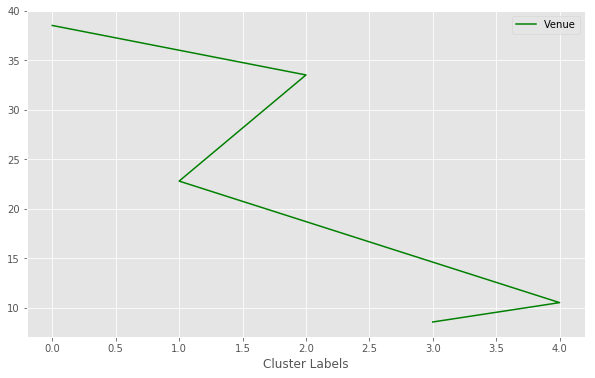

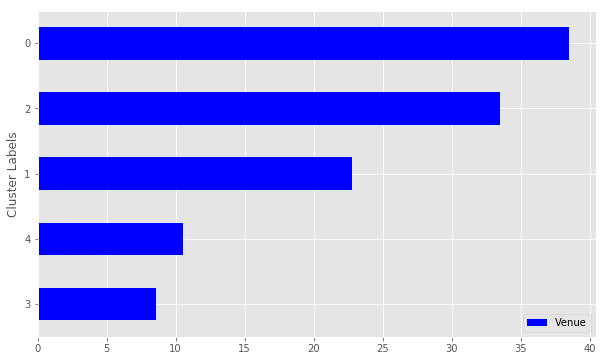

In [257]:
avg.sort_values(['Venue'], ascending=True).plot(kind='line', figsize=(10,6), color="green")
avg.sort_values(['Venue'], ascending=True).plot(kind='barh', figsize=(10,6), color="blue")

## Now Lets take a look at the map screenshot of Cluster3

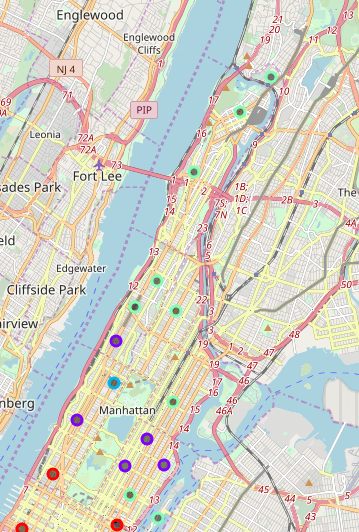

In [258]:
from PIL import Image
import requests
from io import BytesIO

response = requests.get('https://i.imgur.com/OG2yvLr.png')
img = Image.open(BytesIO(response.content))
img

## Here I have isolated 3 possible areas for opening a new Thai Restaurant

### 2 out of 3 areas are generally alongside Broadway in the upper northern part of Manhattan

### Broadway is highly popular street on Manhattan and that might be a good choice for a new restaurant, however that popularity might come at a price of higher rent for instance, in that case the 3rd area might be a suitable location located mostly in Harlem, surrounded by Broadway on the west, Central Park on the south and extending towards The City College of New York.


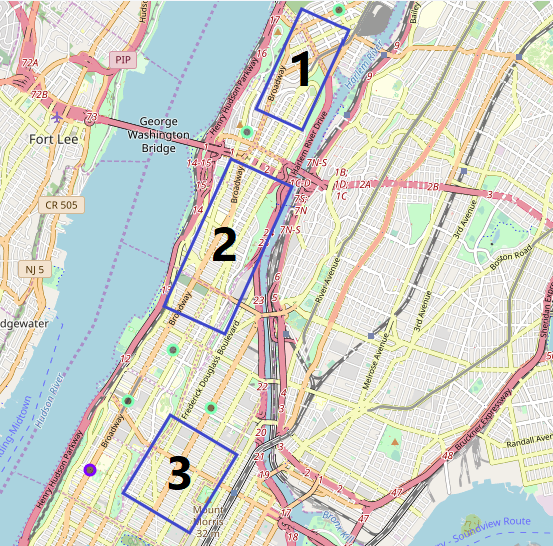

In [259]:
from PIL import Image
import requests
from io import BytesIO

response = requests.get('https://i.imgur.com/gLyOOOh.png')
img2 = Image.open(BytesIO(response.content))
img2

## Thank You for reading
copyright @ Zvonimir Klenovic 2019